In [1]:
import warnings
import pandas as pd
import numpy as np
import itertools
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta
warnings.filterwarnings('ignore')


def download_yahoo_data(ticker, start_date):
    yahoo_data = yf.download(ticker, start=start_date, progress=False)
    return yahoo_data

In [2]:
# Загрузка данных S&P 500

start_date = "2007-01-01"
index_ticker = "^GSPC"  # S&P 500
index_data = download_yahoo_data(index_ticker, start_date)[['Adj Close', 'Volume']]
index_data['Date'] = index_data.index
index_data.reset_index(drop=True, inplace=True)
index_data.head()

# Загрузка данных о 10-летней ставке бондов США
tnx_ticker = "^TNX"
tnx_data = download_yahoo_data(tnx_ticker, start_date)[['Adj Close']] / 100
tnx_data['Date'] = tnx_data.index
tnx_data.reset_index(drop=True, inplace=True)

# Загрузка данных уровня страха VIX
vix_ticker = "^VIX"
vix_data = download_yahoo_data(vix_ticker, start_date)[['Adj Close']] / 100
vix_data['Date'] = vix_data.index
vix_data.reset_index(drop=True, inplace=True)


# Объединение данных S&P 500 и данных о ставке бондов по датам
merged_data = pd.merge(index_data, tnx_data, on='Date', suffixes=('_S&P500', '_TNX'))
merged_data = merged_data.merge(vix_data, on='Date')
merged_data = merged_data.rename({'Adj Close': 'Adj Close_VIX'}, axis=1)

merged_data['Index_returns'] = np.log(merged_data['Adj Close_S&P500']).diff()
merged_data['VIX_returns'] = np.log(merged_data['Adj Close_VIX']).diff()

# Вычисление реализованной волатильности
window_size = 20  # Размер скользящего окна
merged_data['Realized_volatility'] = merged_data['Index_returns'].rolling(window=window_size).std() * np.sqrt(252)
merged_data.dropna(inplace = True)


# Вычисление отклонения от среднего для объёма
merged_data['YearMonth'] = merged_data['Date'].dt.strftime('%Y-%m')
grouped_data = merged_data.copy()
grouped_data = grouped_data.groupby(['YearMonth'])['Volume'].mean().reset_index()
grouped_data = grouped_data.set_axis(['YearMonth', 'MeanVolume'], axis=1)
merged_data = merged_data.merge(grouped_data, on='YearMonth', how='left')
merged_data['Deviation_Volume'] = (merged_data['Volume'] - merged_data['MeanVolume'])/ merged_data['MeanVolume']
merged_data.head()
# # Определение порога для классификации периодов кризиса
# threshold = merged_data['Index_returns'].quantile(0.9999)  # 99-й квантиль

# #merged_data.head()
# print(threshold)

# Определение порога для классификации периодов кризиса
negative_returns = merged_data[merged_data['Index_returns'] < 0]['Index_returns']
threshold = negative_returns.quantile(0.9999)  # 99-й квантиль отрицательных значений

#print("Порог для классификации кризиса:", threshold)

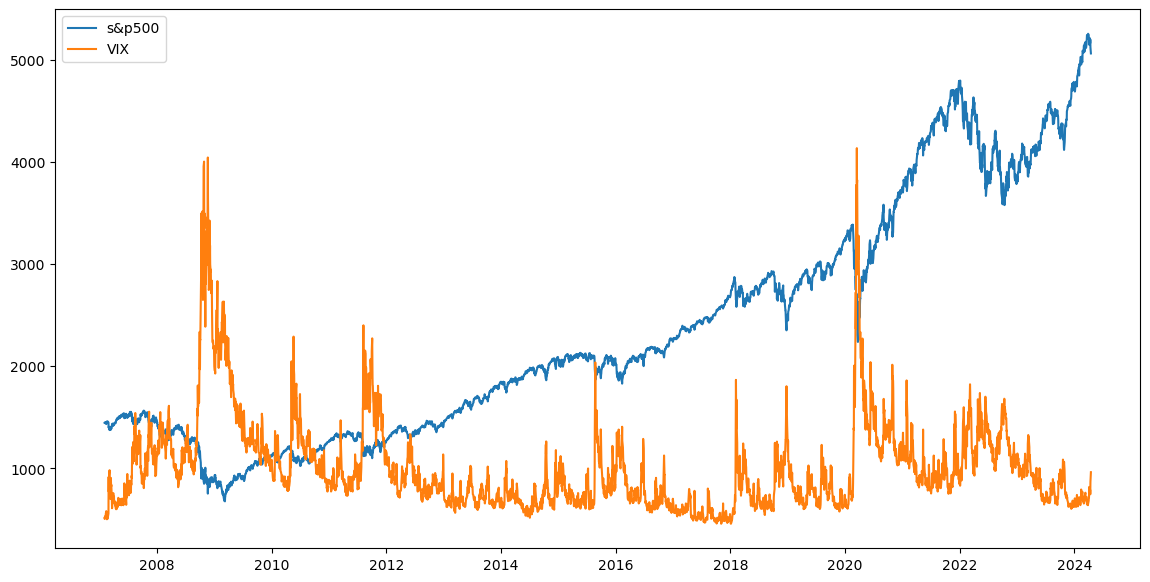

In [3]:
# Рисуем график, видим, что уровень стараха повышается на резких падениях без задержки

plt.figure(figsize=(14, 7))
plt.plot(merged_data['Date'], merged_data['Adj Close_S&P500'], label='s&p500')
#plt.plot(merged_data['Date'], merged_data['Volume']/3000000, label='Volume')
plt.plot(merged_data['Date'], merged_data['Adj Close_VIX']*5000, label='VIX')
plt.legend()

In [4]:
# # Загрузка данных о 10-летней ставке бондов США
# tnx_ticker = "^TNX"
# tnx_data = download_yahoo_data(tnx_ticker, start_date)[['Adj Close']] / 100
# tnx_data['Date'] = tnx_data.index
# tnx_data.reset_index(drop=True, inplace=True)

In [5]:
# # Объединение данных S&P 500 и данных о ставке бондов по датам
# merged_data = pd.merge(index_data, tnx_data, on='Date', suffixes=('_S&P500', '_TNX'))

# merged_data['Index_returns'] = np.log(merged_data['Adj Close_S&P500']).diff()

# # Вычисление реализованной волатильности
# window_size = 20  # Размер скользящего окна
# merged_data['Realized_volatility'] = merged_data['Index_returns'].rolling(window=window_size).std() * np.sqrt(252)
# merged_data.dropna(inplace = True)

# # Определение порога для классификации периодов кризиса
# threshold = merged_data['Index_returns'].quantile(0.9999)  # 99-й квантиль

# #merged_data.head()
# print(threshold)

In [6]:
# Создание бинарной переменной для периодов кризиса (1 - период кризиса, 0 - период без кризиса)
merged_data['Crisis'] = np.where(merged_data['Index_returns'] > threshold, 1, 0)

# Сброс индекса перед созданием лаговой структуры
merged_data.reset_index(drop=True, inplace=True)
merged_data['Date'] = pd.to_datetime(merged_data['Date'])

# Создание лаговых переменных
def lags_variable(bias):
    for i in range(bias):
        num = str(i+1)
        merged_data[f'lag{num}_Index_returns'] = merged_data['Index_returns'].shift(i+1)
        #merged_data[f'lag{num}_Adj_Close_TNX'] = merged_data['Adj Close_TNX'].shift(i+1)
        merged_data[f'lag{num}_Realized_volatility'] = merged_data['Realized_volatility'].shift(i+1)
        #merged_data[f'lag{num}_Deviation_Volume'] = merged_data['Deviation_Volume'].shift(i+1)
        merged_data[f'lag{num}_VIX_returns'] = merged_data['VIX_returns'].shift(i+1)

count_lag = 3
lags_variable(count_lag)

# Удаляем строки с пропущенными значениями после создания лагов
merged_data.dropna(inplace=True)

# Разделение выборки на тренировочную и тестовую
train = merged_data
test =  merged_data[merged_data['Date'] >= '2023-01-01']

# # Построение графика исходного ряда S&P 500 и TNX
# plt.figure(figsize=(14, 7))
# plt.plot(merged_data['Date'], merged_data['Adj Close_S&P500'] / 100000, label='S&P 500')
# plt.plot(merged_data['Date'], merged_data['Adj Close_TNX'], label='TNX')
# plt.legend()

# Инициализация и обучение модели TAR
exog = [f'lag{str(i+1)}_Index_returns' for i in range(count_lag)]
#exog += [f'lag{str(i+1)}_Adj_Close_TNX' for i in range(count_lag)]
exog += [f'lag{str(i+1)}_Realized_volatility' for i in range(count_lag)]
#exog += [f'lag{str(i+1)}_Deviation_Volume' for i in range(count_lag)]
exog += [f'lag{str(i+1)}_VIX_returns' for i in range(count_lag)]
model = MarkovRegression(train['Index_returns'], k_regimes=2, trend='c', exog=train[exog])
result = model.fit(em_iter=5)

# Получение прогнозов для состояний
predict_regime = result.smoothed_marginal_probabilities[0]

In [7]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:          Index_returns   No. Observations:                 4324
Model:               MarkovRegression   Log Likelihood               13374.289
Date:                Mon, 15 Apr 2024   AIC                         -26702.578
Time:                        23:17:07   BIC                         -26556.024
Sample:                             0   HQIC                        -26650.834
                               - 4324                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0043      0.001      7.855      0.000       0.003       0.005
x1            -0.0461      0.041     -1.127      0.260      -0.126       0.034
x2             0.0480      0.035      1.353      0.176      -0.022       0.117
x3             0.0172      0.033      0.516      0.606      -0.048       0.082
x4            -0.1010      0.026     -3.889      0.000      -0.152      -0.050
x5            -0.1512      0.039     -3.864      0.000      -0.228      -0.075
x6             0.1928      0.024      8.140      0.000       0.146       0.239
x7            -0.0098      0.007     -1.496      0.135      -0.023       0.003
x8            -0.0050      0.006     -0.775      0.438      -0.018       0.008
x9            -0.0148      0.006     -2.586      0.010      -0.026      -0.004
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0024      0.000     -6.076      0.000      -0.003      -0.002
x1            -0.2779      0.026    -10.503      0.000      -0.330      -0.226
x2            -0.1500      0.026     -5.868      0.000      -0.200      -0.100
x3            -0.0906      0.026     -3.476      0.001      -0.142      -0.040
x4             0.0370      0.019      1.993      0.046       0.001       0.073
x5             0.0538      0.028      1.920      0.055      -0.001       0.109
x6            -0.0503      0.020     -2.550      0.011      -0.089      -0.012
x7            -0.0147      0.004     -3.396      0.001      -0.023      -0.006
x8            -0.0074      0.004     -1.735      0.083      -0.016       0.001
x9            -0.0029      0.004     -0.670      0.503      -0.011       0.006
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      9.399e-05   2.38e-06     39.486      0.000    8.93e-05    9.87e-05
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.4434      0.041     10.856      0.000       0.363       0.523
p[1->0]        0.3389      0.034     10.035      0.000       0.273       0.405
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differ

In [8]:
# # Инициализация и обучение модели TAR
# exog = [f'lag{str(i+1)}_Index_returns' for i in range(count_lag)]
# exog += [f'lag{str(i+1)}_Adj_Close_TNX' for i in range(count_lag)]
# model = MarkovRegression(train['Index_returns'], k_regimes=2, trend='c', exog=train[exog])
# result = model.fit(em_iter=5)

# # Получение прогнозов для состояний
# predict_regime = result.smoothed_marginal_probabilities[0]

In [9]:
result.aic #10

-26702.578374778313

In [10]:
result.aic #3

-26702.578374778313

In [11]:
result.aic #10 + volatility + кризис это только 0,9999 квантиль отрицательных доходностей

-26702.578374778313

In [12]:
result.aic #10 + volatility

-26702.578374778313

In [13]:
predict_regime.median()

0.36958703392585857

In [14]:
train['Date'] = pd.to_datetime(train['Date'])
train['Date'].dtype

dtype('<M8[ns]')

In [15]:
# деление выборки на кризс/не кризис по месяцам
train['crisis_day'] = np.where(predict_regime > 0.5, 1, 0)
train['crisis_day'].sum()

train['crisis_month'] = 0
start_date = datetime(2007, 1, 1)  # Начальная дата (1 января 2007 года)
end_date = datetime(2022, 12, 31)  # Конечная дата (31 декабря 2023 года)
end_date_2 = datetime(2007, 3, 1)

current_date = start_date
last_tree_month_sum = 0
tree_month = [0, 0, 0]
binary_month = [1, 0, 0]

while current_date <= end_date_2:
    year = current_date.year
    month = current_date.month
    mask = (train['Date'].dt.year == year) & (train['Date'].dt.month == month)
    crisis_sum_days = train[mask]['crisis_day'].sum()
    if binary_month[0] == 0:
        tree_month[0] = crisis_sum_days
    elif binary_month[1] == 0:
        tree_month[1] = crisis_sum_days
    elif binary_month[2] == 0:
         tree_month[2] = crisis_sum_days
    current_date = current_date.replace(month=current_date.month+1)

print(tree_month, 'суммы в первые три месяца')
current_date = start_date
while current_date <= end_date:
    year = current_date.year
    month = current_date.month
    mask = (train['Date'].dt.year == year) & (train['Date'].dt.month == month)
    crisis_sum_days = train[mask]['crisis_day'].sum()
    if sum(tree_month) >= 20:
        if month == 3:
            mask1 = (train['Date'].dt.year == year) & (train['Date'].dt.month == 2)
            mask2 = (train['Date'].dt.year == year) & (train['Date'].dt.month == 1)
            mask3 = (train['Date'].dt.year == year-1) & (train['Date'].dt.month == 12)
            train.loc[mask1, 'crisis_month'] = 1
            train.loc[mask2, 'crisis_month'] = 1
            train.loc[mask3, 'crisis_month'] = 1
        elif month == 2:
            mask1 = (train['Date'].dt.year == year) & (train['Date'].dt.month == 1)
            mask2 = (train['Date'].dt.year == year-1) & (train['Date'].dt.month == 12)
            mask3 = (train['Date'].dt.year == year-1) & (train['Date'].dt.month == 11)
            train.loc[mask1, 'crisis_month'] = 1
            train.loc[mask2, 'crisis_month'] = 1
            train.loc[mask3, 'crisis_month'] = 1
        elif month == 1:
            mask1 = (train['Date'].dt.year == year-1) & (train['Date'].dt.month == 12)
            mask2 = (train['Date'].dt.year == year-1) & (train['Date'].dt.month == 11)
            mask3 = (train['Date'].dt.year == year-1) & (train['Date'].dt.month == 10)
            train.loc[mask1, 'crisis_month'] = 1
            train.loc[mask2, 'crisis_month'] = 1
            train.loc[mask3, 'crisis_month'] = 1
        else:
            mask1 = (train['Date'].dt.year == year) & (train['Date'].dt.month == month-1)
            mask2 = (train['Date'].dt.year == year) & (train['Date'].dt.month == month-2)
            mask3 = (train['Date'].dt.year == year) & (train['Date'].dt.month == month-3)
            train.loc[mask1, 'crisis_month'] = 1
            train.loc[mask2, 'crisis_month'] = 1
            train.loc[mask3, 'crisis_month'] = 1
    
    tree_month[0] = tree_month[1]
    tree_month[1] = tree_month[2]
    tree_month[2] = crisis_sum_days
    
    if current_date.month == 12:
        current_date = current_date.replace(year=current_date.year+1, month=1)
    else:
        current_date = current_date.replace(month=current_date.month+1)



[0, 5, 0] суммы в первые три месяца


In [16]:
train['crisis_month'].sum()

1172

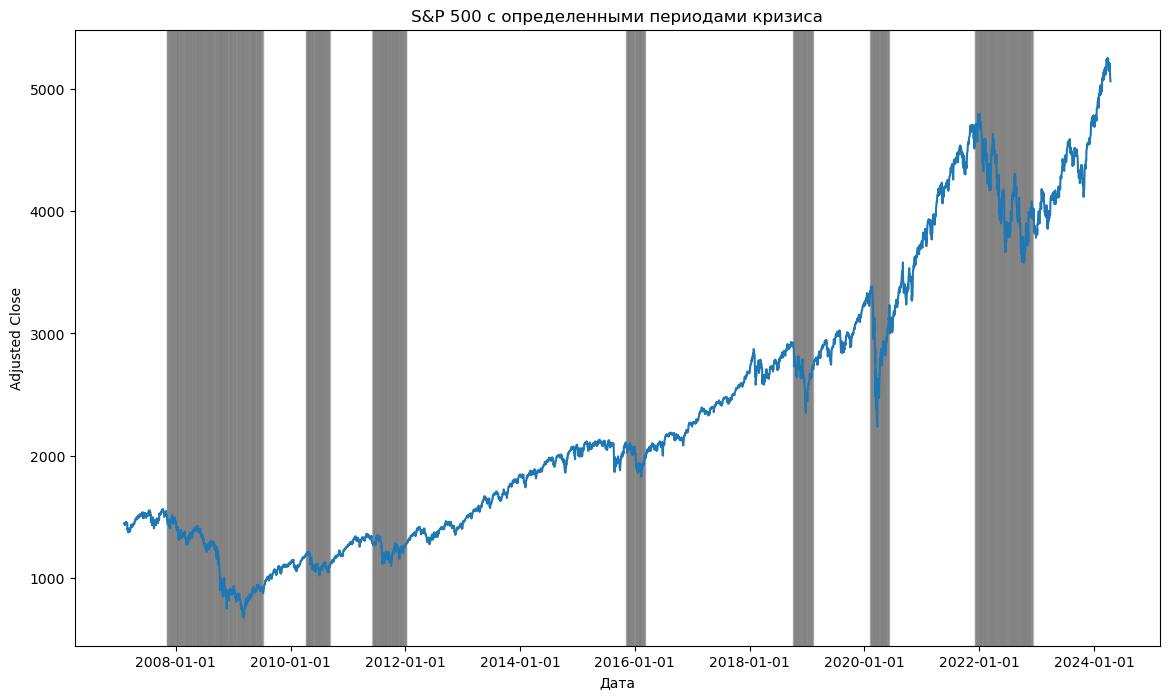

In [17]:
import matplotlib.dates as mdates

plt.figure(figsize=(14, 8))

# Наложение серого фона только на кризисные периоды
for i, row in train.iterrows():
    if row['crisis_month'] == 1:  # Если модель определила текущий период как кризисный
        if i + 1 < len(train):
            plt.axvspan(train['Date'].iloc[i], train['Date'].iloc[i + 1], color='gray', alpha=0.3)
        else:
            plt.axvspan(train['Date'].iloc[i], train['Date'].iloc[i], color='gray', alpha=0.3)

plt.plot(train['Date'], train['Adj Close_S&P500'])

plt.title('S&P 500 с определенными периодами кризиса')
plt.xlabel('Дата')
plt.ylabel('Adjusted Close')

# Задание формата дат для оси X
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.show()

In [18]:
predict = model.predict(test['Index_returns'])
predict

array([nan, nan, nan, ..., nan, nan, nan])

In [24]:
grouped_data = train[['Date', 'YearMonth', 'crisis_month']].groupby(['YearMonth']).max()
grouped_data['crisis_month'].to_csv('crisis_months.csv')

Enumerating objects: 11, done.
Counting objects: 100% (11/11), done.
Delta compression using up to 8 threads
Compressing objects: 100% (6/6), done.
Writing objects: 100% (6/6), 65.73 KiB | 7.30 MiB/s, done.
Total 6 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To github.com:Ranks-LLC/ranks-ds.git
   b11441f..0ed3d49  feature/add_period_in_crisis_model -> feature/add_period_in_crisis_model


In [81]:
index_data = download_yahoo_data(index_ticker, start_date)
index_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2007-01-03,1418.030029,1429.420044,1407.859985,1416.599976,1416.599976,3429160000
2007-01-04,1416.599976,1421.839966,1408.430054,1418.339966,1418.339966,3004460000
2007-01-05,1418.339966,1418.339966,1405.750000,1409.709961,1409.709961,2919400000
2007-01-08,1409.260010,1414.979980,1403.969971,1412.839966,1412.839966,2763340000
2007-01-09,1412.839966,1415.609985,1405.420044,1412.109985,1412.109985,3038380000
...,...,...,...,...,...,...
2024-04-04,5244.049805,5256.589844,5146.060059,5147.209961,5147.209961,4075680000
2024-04-05,5158.950195,5222.180176,5157.209961,5204.339844,5204.339844,3386780000
2024-04-08,5211.370117,5219.569824,5197.350098,5202.390137,5202.390137,3278180000
